In [1]:
import re
import pandas as pd
import plotly.express as px
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Reading the file

In [2]:
filename = 'conversas.txt'

In [3]:
#RETURN TRUE IF THIS IS A DATA LINE
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)\/([0-9]+)\/([0-9]+) ([0-9]+):([0-9]+) ?[AaPp]?[Mm]? -' 
    if re.match(pattern, s):
        return True
    return False

In [4]:
startsWithDateAndTime('7/26/18 22:51 - Bobby: Lorem ipsum dolor sit amet')

True

In [5]:
#RETURN TRUE IF HAS AN AUTHOR ON THE DATA LINE
def hasAuthor(s):
    if(startsWithDateAndTime(s)):
        s=s.split(":")
        if len(s)>2:
            return True
        else:
            return False
    else:
        return False

In [6]:
print(hasAuthor('02/08/2020 16:56 - +55 84 9832-0571: Ofereço: cidade a cidade'))
print(hasAuthor('02/08/2020 17:09 - +55 84 9932-0091: Bom dia!'))
print(hasAuthor('31/03/2018 01:04 - Você foi adicionado(a)'))
print(hasAuthor('fsdfjsf'))

True
True
False
False


In [7]:
#GET INFORMATION FROM THE DATA LINE
def getInformation(s):
    dateMessageSplit = s.split(' - ')
    date,time = dateMessageSplit[0].split(' ')
    message = ' - '.join(dateMessageSplit[1:])
    author = None
    if(hasAuthor(s)):
        author = message.split(':')[0]
        message = ': '.join(message.split(': ')[1:])
    return date,time,author,message

In [8]:
getInformation('02/08/2020 17:09 - +55 84 9932-0091: Bom dia!')
getInformation('02/08/2020 16:56 - +55 84 9832-0571: Ofereço: cidade a cidade')

('02/08/2020', '16:56', '+55 84 9832-0571', 'Ofereço: cidade a cidade')

In [9]:
%%time
messageList=[]
with open(filename,encoding='utf-8') as file:
    messageBuffer=[]
    date,time,author,message = None,None,None,None
    while(True):
        line = file.readline()
        if not line: 
            break
        line = line.strip()
        #IF IS A DATA LINE
        if startsWithDateAndTime(line):
            if len(messageBuffer) > 0: 
                messageList.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date,time,author,message = getInformation(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

CPU times: user 26.1 ms, sys: 4.43 ms, total: 30.5 ms
Wall time: 73.3 ms


# Creating and changing the dataframe

In [10]:
df = pd.DataFrame(messageList, columns=['date', 'time', 'author', 'message'])
df["date"] = pd.to_datetime(df["date"],dayfirst=True)
df.head(10)

date   time   author  \
0 2019-04-25  01:25  person2   
1 2019-07-31  08:04  person3   
2 2019-12-26  11:52  person6   
3 2019-06-12  13:43  person1   
4 2019-07-24  04:01  person1   
5 2019-12-12  20:09  person6   
6 2019-04-18  22:38  person2   
7 2019-04-13  04:06  person3   
8 2019-05-19  10:52  person1   
9 2019-01-29  08:18  person3   

                                             message  
0  Lorem ipsum dolor sit amet, consectetur adipis...  
1                        Nam aliquet sapien lectus.😍  
2  Interdum et malesuada fames ac ante ipsum prim...  
3               faucibus. Praesent ac quam at turpis  
4  facilisis bibendum at a felis. Morbi tincidunt...  
5  ullamcorper aliquet. Duis ante justo, facilisi...  
6                                         sagittis🤮😁  
7             non nisi. Pellentesque sodales tempus😬  
8  nisi, non consequat magna rutrum vitae. Nam li...  
9  eu malesuada vitae, vulputate vitae tortor. Mo...

In [11]:
#CREATE A WORD LIST COLUMN FORM MESSAGE
word_pattern = r"([\w]+)"
digit_pattern = r"([\d]+)"
df['word']=df["message"].str.upper().str.replace(digit_pattern,'').str.findall(word_pattern)

In [12]:
#CREATE EMOJI LIST COLUMN FROM MESSAGE
def getEmojis(s):
    return [c for c in s if c in emoji.UNICODE_EMOJI]
df['emoji'] = df["message"].apply(getEmojis)

In [13]:
#CREATE DOMAIN LIST COLUMN FROM URL
domain_pattern = r"https?://([\w.]+)"
df['domain']=df["message"].str.findall(domain_pattern)

# Cleanning

In [14]:
df = df.dropna(subset=['author'])
df = df.loc[~(df.message.str.contains("<Arquivo de mídia oculto>"))]
df

date   time   author  \
0    2019-04-25  01:25  person2   
1    2019-07-31  08:04  person3   
2    2019-12-26  11:52  person6   
3    2019-06-12  13:43  person1   
4    2019-07-24  04:01  person1   
...         ...    ...      ...   
2413 2019-10-26  23:28  person1   
2414 2019-08-29  16:25  person5   
2415 2018-01-27  02:43  person0   
2416 2019-07-24  15:33  person6   
2417 2019-02-06  09:17  person9   

                                                message  \
0     Lorem ipsum dolor sit amet, consectetur adipis...   
1                           Nam aliquet sapien lectus.😍   
2     Interdum et malesuada fames ac ante ipsum prim...   
3                  faucibus. Praesent ac quam at turpis   
4     facilisis bibendum at a felis. Morbi tincidunt...   
...                                                 ...   
2413                                       condimentum🤑   
2414                              velit blandit dictum.   
2415                                   Fusce mollis non   
2416                                          neque id🤕   
2417  malesuada. Proin molestie sed lectus et facili...   

                                                   word emoji domain  
0     [LOREM, IPSUM, DOLOR, SIT, AMET, CONSECTETUR, ...    []     []  
1                        [NAM, ALIQUET, SAPIEN, LECTUS]   [😍]     []  
2     [INTERDUM, ET, MALESUADA, FAMES, AC, ANTE, IPS...    []     []  
3            [FAUCIBUS, PRAESENT, AC, QUAM, AT, TURPIS]    []     []  
4     [FACILISIS, BIBENDUM, AT, A, FELIS, MORBI, TIN...    []     []  
...                                                 ...   ...    ...  
2413                                      [CONDIMENTUM]   [🤑]     []  
2414                           [VELIT, BLANDIT, DICTUM]    []     []  
2415                               [FUSCE, MOLLIS, NON]    []     []  
2416                                        [NEQUE, ID]   [🤕]     []  
2417  [MALESUADA, PROIN, MOLESTIE, SED, LECTUS, ET, ...   [🙃]     []  

[2418 rows x 7 columns]

# Showing information

In [15]:
#RETURN A PANADAS DATAFRAME WITH THE LIST OF ALL ITEMS FROM A COLUMN WITH LISTS INT THE DATAFRAME
def toUniqueList(serie):
    uniqueList=[]
    for row in serie:
        uniqueList+=row
    return pd.DataFrame(uniqueList)
#CREATE A DATAFRAME WITH THE COUNT OF A LIST OF ITEMS FROM A LIST-COLUMN
def countDataframe(serie):
    return pd.DataFrame(toUniqueList(serie).value_counts(),columns=["count"]).reset_index().rename(columns={0:"item"})

In [16]:
#EMOTICONS
if len(toUniqueList(df.emoji))!=0:
    fig = px.pie(countDataframe(df.emoji).head(10),values='count',names='item')
    fig.update_traces(textposition='inside', textinfo='percent+label',
                      title="Top 10 emoticons mais usados")
    fig.show()

In [17]:
#PALAVRAS
fig = px.pie(countDataframe(df.word).head(20),values='count',names='item')
fig.update_traces(textposition='inside', textinfo='percent+label',
                  title="Top 20 palavras mais utilizadas")
fig.show()

In [18]:
#SITES
if len(toUniqueList(df.domain))!=0:
    fig = px.bar(toUniqueList(df.domain),title="Dominios de sites mais comentados do grupo")
    fig.show()

In [19]:
#PESSOAS
fig = px.bar(df.author.value_counts().head(20),title="Top 20 pessoas que mais falam")
fig.show()

In [20]:
#MENSAGENS PELO TEMPO
fig = px.bar(df.date.value_counts().sort_index(),title="Mensagens por dia")
fig.show()

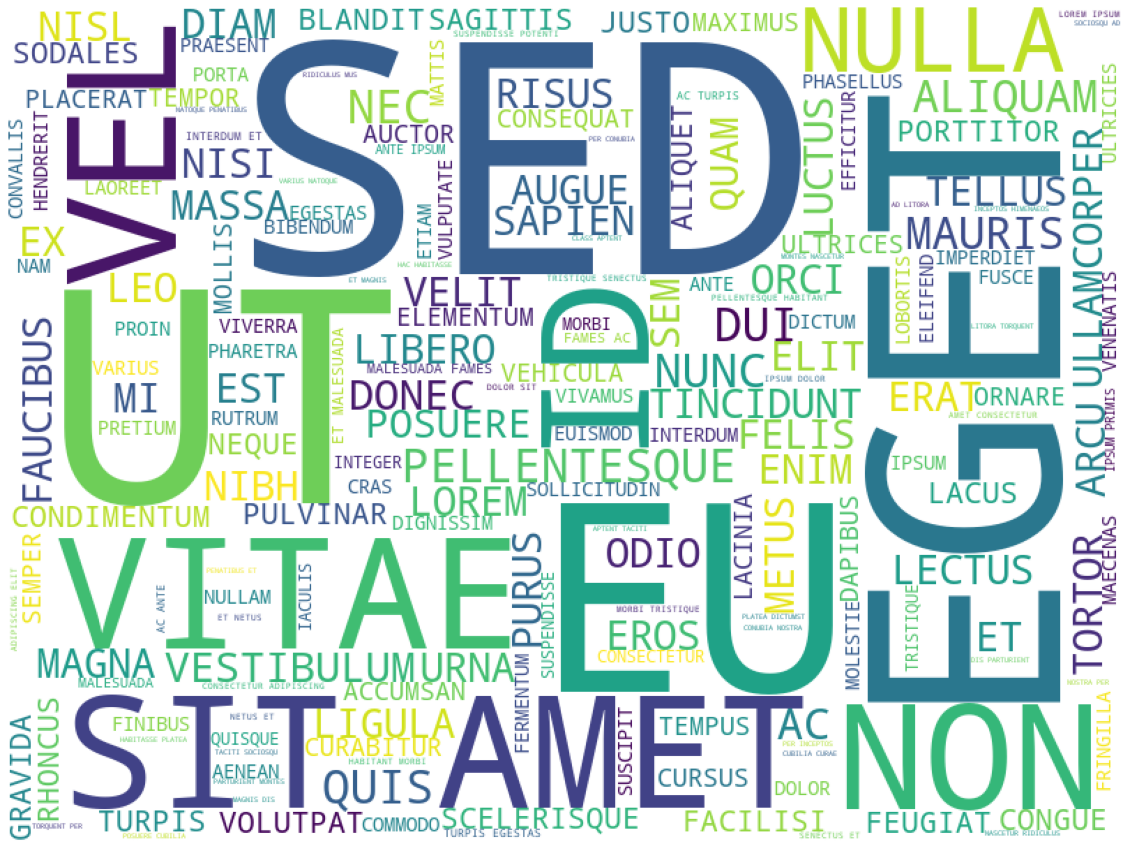

In [21]:
#CREATE WORDCLOUD
complete_text = ' '.join(toUniqueList(df.word)[0])
wordcloud = WordCloud(max_words=200, background_color="white",width=800,height=600).generate(complete_text)
wordcloud.to_file("wordcloud.png")
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wordcloud)
plt.show()